In [11]:
# Standard Imports
import numpy as np
from time import time
from matplotlib import pyplot as plt
import os


from pyspecter.SPECTER import SPECTER
from pyspecter.Observables import Observable
# from pyspecter.SpecialObservables import SpecialObservables

# Utils
from pyspecter.utils.data_utils import load_cmsopendata, load_triangles
from pyspecter.utils.plot_utils import newplot, plot_event, hist_with_errors, hist_with_outline, stamp

# Jax
from jax import grad, jacobian, jit
import jax.numpy as jnp
from jax import random

# SPECTER
from pyspecter.SpectralEMD_Helper import compute_spectral_representation

In [12]:
R = 0.1
this_dir = ""
this_study = "cmsopendata"

# Load the params 
specter_params_string = f"{this_study}_params.npy"
closed_form_params_string = f"{this_study}_closed_form_params.npy"
shaper_params_string = f"{this_study}_shaper_params.npy"

specter_params = np.load(os.path.join(this_dir, specter_params_string), allow_pickle=True)
closed_form_params = np.load(os.path.join(this_dir, closed_form_params_string), allow_pickle=True)
shaper_params = np.load(os.path.join(this_dir, shaper_params_string), allow_pickle=True)

# Load the EMDs
specter_emds_string = f"{this_study}_sEMDs.npy"
closed_form_emds_string = f"{this_study}_closed_form_sEMDs.npy"
shaper_emds_string = f"{this_study}_shaper_EMDs.npy"

specter_emds = np.load(os.path.join(this_dir, specter_emds_string), allow_pickle=True)
closed_form_emds = np.load(os.path.join(this_dir, closed_form_emds_string), allow_pickle=True)
shaper_emds = np.load(os.path.join(this_dir, shaper_emds_string), allow_pickle=True)

# Parameters 
n_events = 100
epochs = 150

dataset_open, sim_weights, k = load_cmsopendata("~/.energyflow/", "sim", 475, 525, 1.9, 2, pad = 75, n = n_events)
triangle_events, triangle_indices = load_triangles(180, 180, R = 1.0, return_indices=True)

dataset = dataset_open


Max # of particles: 113


Text(0, 0.5, 'Spectral Density $\\sim 2E_iE_j$')

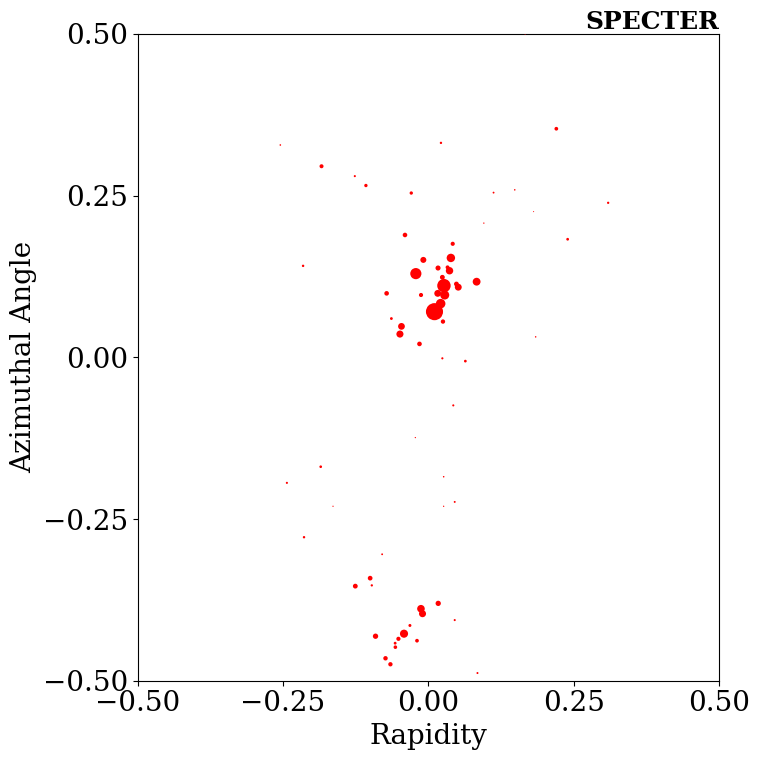

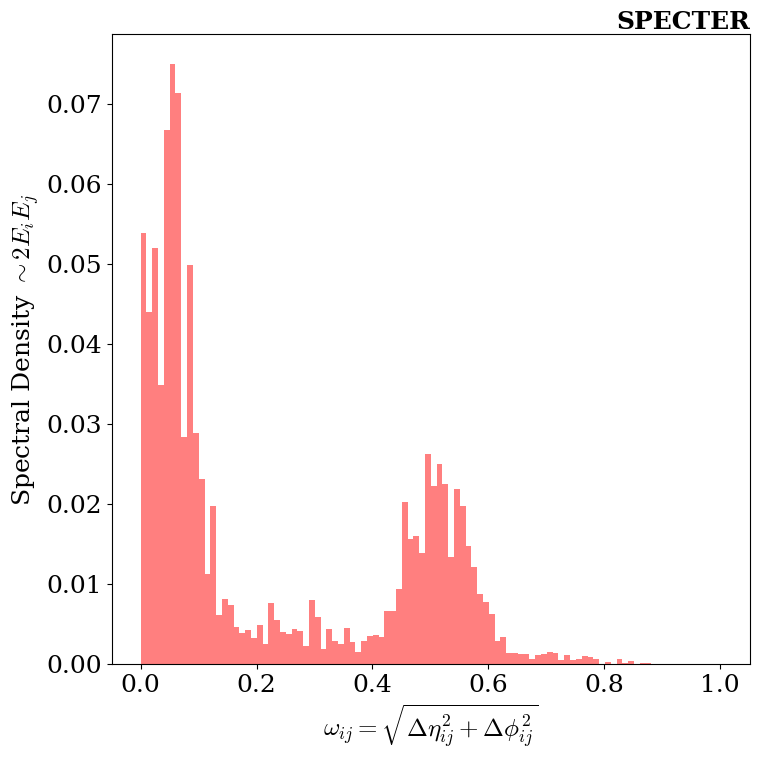

In [13]:
special_event = dataset[0]
fig, ax = newplot()
plot_event(ax, special_event, 0.5, color = "red")

special_event = compute_spectral_representation(special_event)
fig, ax = newplot()
plt.hist(special_event[:,0], bins = 100, color = "red", alpha = 0.5, weights = special_event[:,1])
plt.xlabel(r"$\omega_{ij} = \sqrt{\Delta\eta_{ij}^2 + \Delta\phi_{ij}^2}$")
plt.ylabel(r"Spectral Density $\sim 2E_iE_j$")



Text(0, 0.5, '$\\mathrm{EMD}_{\\mathrm{SPECTER}}$')

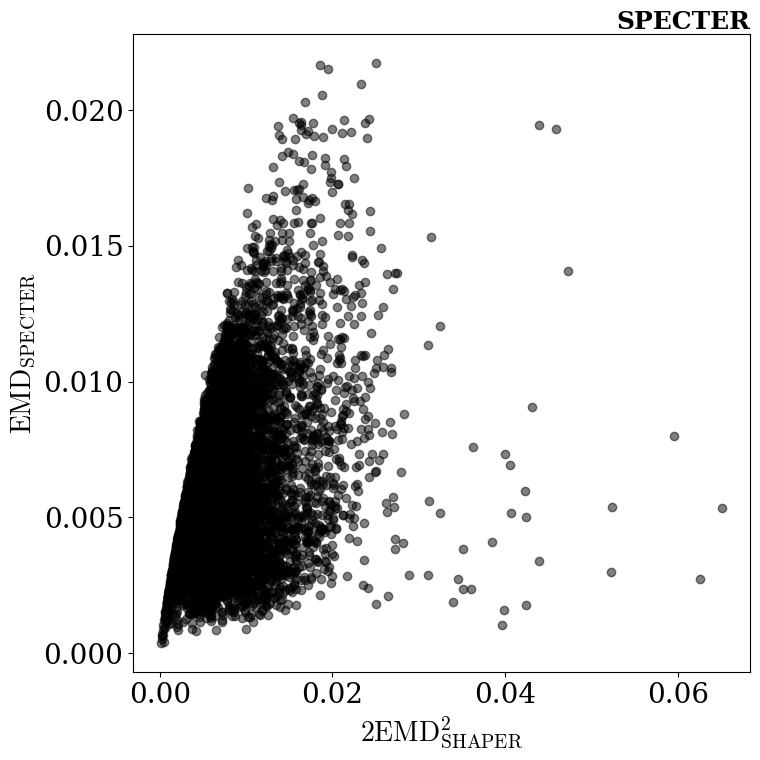

In [19]:
# Plot the SPECTER EMD vs the SHAPER EMD

fig, ax = newplot()
plt.scatter(2 * shaper_emds, specter_emds, color = "black", alpha = 0.5)

plt.xlabel(r"$2\mathrm{EMD}_{\mathrm{SHAPER}}^2$")
plt.ylabel(r"$\mathrm{EMD}_{\mathrm{SPECTER}}$")


In [15]:
# weights such that the points near 0.2 of specter_params have half weight
def reweight(params):

    weights = np.ones_like(params)
    for (i,param) in enumerate(params):
        if param > 0.18 and param < 0.22:
            weights[i] = 0.6

    return weights

weights = reweight(specter_params)


In [16]:
alpha_s = 0.12
C_F = 4/3
C_A = 3
T_R = 0.5
n_f = 5

def quark_splitting_function(z):

    return C_F * (1 + (1-z)**2) / z

def gluon_splitting_function(z):

    return C_A * (1-z) / z + C_A * (1-z)/z + C_A * z * (1-z) + T_R * n_f * (1-z)**2

def theta(z, R_opt, R = 0.5):

    t = 2 * R * np.sin(z[None,:] * (1-z[None,:]) * np.pi) - np.pi * R_opt[:,None]
    return t > 0



def integral(R_opt, theta = theta, n = 1000):

    z = np.random.uniform(0, 1, size = n)
    probability = 0.5 * quark_splitting_function(z) + 0.5 * gluon_splitting_function(z)
    t = theta(z, R_opt)
    return alpha_s / np.pi * np.sum(probability * t, axis = -1)



R_opt = np.linspace(0.001, 0.35 , 10000)
probs = integral(R_opt)

0.08941676729925675 0.086695835 0.06911109


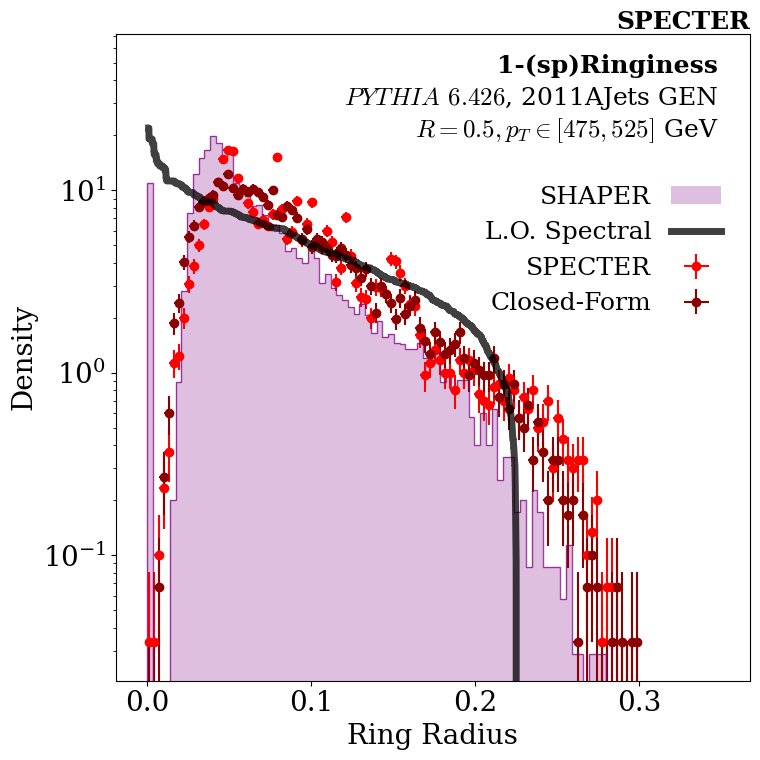

In [17]:
# Plot histograms


fig, ax = newplot()

hist_with_errors(ax, specter_params, 100, (0, 0.3),  label=r"SPECTER", color = "red")
hist_with_errors(ax, closed_form_params, 100, (0, 0.3), label="Closed-Form", color = "darkred")
hist_with_outline(ax, shaper_params, 100, (0, 0.35), label=r"SHAPER", color = "purple")

plt.plot(R_opt , 0.02 * probs, color = "black", lw = 5, alpha = 0.75, label = "L.O. Spectral", zorder = 10)
# plt.axvline(0.05, ymin = 1e-2, ymax = 1, color = "red", ls = "--")
# plt.axvline(0.175, ymin = 1e-2, ymax = 1, color = "red", ls = "--")


plt.yscale("log")

# Extend the y axis so that there is 10% space between the top of the plot
ymin, ymax = plt.ylim()
amount = 0.25
if plt.gca().get_yscale() == 'log':
    y_min, y_max = np.log10(ymin), np.log10(ymax)
    plt.ylim(np.power(10, y_min), np.power(10, y_max * (1 + amount)))
else:
    plt.ylim(ymin, ymax * (amount + 1))


print(np.mean(specter_params), np.mean(closed_form_params), np.mean(shaper_params))




# Stamp
line_0 = "1-(sp)Ringiness"
line_1 = "$PYTHIA$ $6.426$, 2011AJets GEN"
line_2 = "$R = 0.5, p_T \in [475, 525]$ GeV"
stamp(0.95, 0.95, line_0 = line_0, line_1 = line_1, line_2 = line_2, textops_update={"fontsize" : 18, "horizontalalignment" : "right"})

# Labels
plt.xlabel("Ring Radius")
plt.ylabel("Density")
legend = plt.legend(frameon=False, loc="upper right", fontsize=18, bbox_to_anchor=(0.99, 0.95 - 0.05 * 3), alignment="right", markerfirst=False)



plt.savefig("Plots/ringiness_radius.pdf")


# # Add two lines of text to the upper left
# upper_margin = 0.96
# spacing = 0.05
# plt.text(0.02, upper_margin - 0 * spacing, "2011AJets GEN", transform=plt.gca().transAxes, verticalalignment='top')
# plt.text(0.02, upper_margin - 1 * spacing, "PYTHIA 6.426", transform=plt.gca().transAxes, verticalalignment='top')
# plt.text(0.02, upper_margin - 2 * spacing, r"$R = 0.5, p_T \in [475, 525] \mathrm{GeV}$", transform=plt.gca().transAxes, verticalalignment='top')

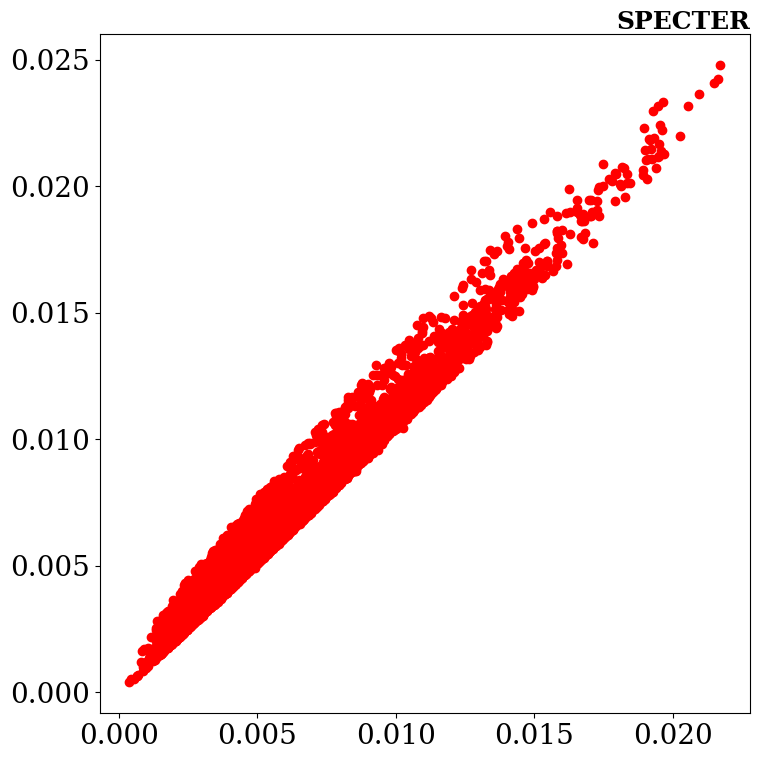

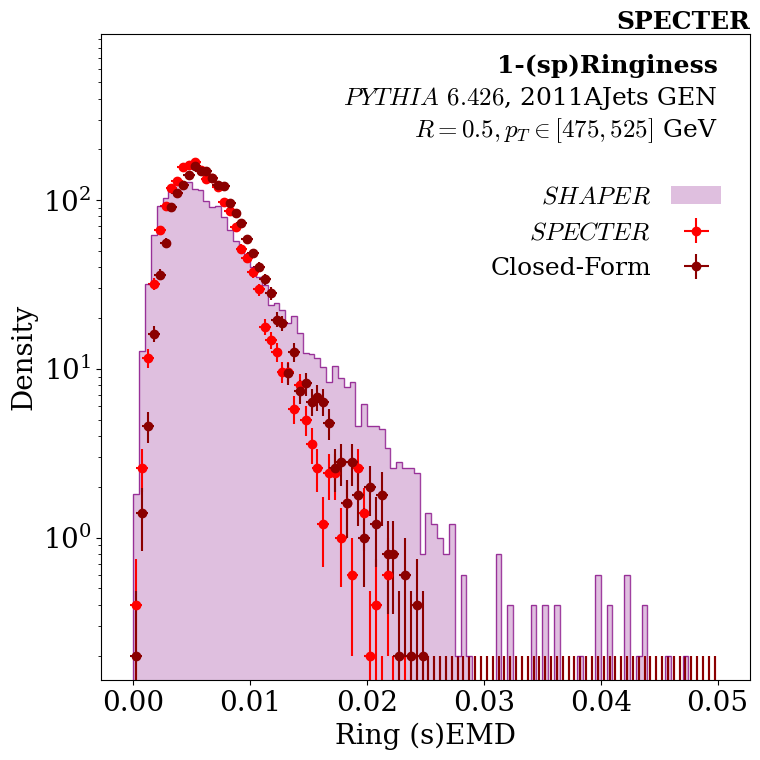

In [22]:
# Plot histograms

fig, ax = newplot()
plt.scatter(specter_emds, closed_form_emds)


fig, ax = newplot()

hist_with_errors(ax, specter_emds, 100, (0, 0.05), label=r"$SPECTER$", color = "red")
hist_with_errors(ax, closed_form_emds, 100, (0, 0.05), label="Closed-Form", color = "darkred")
hist_with_outline(ax, 2 * shaper_emds , 100, (0, 0.05), label=r"$SHAPER$", color = "purple")
# plt.hist(2 * shaper_emds**2, bins=100, range = (0, 0.05), alpha=0.25, label=r"$2SHAPER^2$", density=True, color = "purple")



plt.yscale("log")

# Extend the y axis so that there is 10% space between the top of the plot
ymin, ymax = plt.ylim()
amount = 0.25
if plt.gca().get_yscale() == 'log':
    y_min, y_max = np.log10(ymin), np.log10(ymax)
    plt.ylim(np.power(10, y_min), np.power(10, y_max * (1 + amount)))
else:
    plt.ylim(ymin, ymax * (amount + 1))


# Stamp
line_0 = "1-(sp)Ringiness"
line_1 = "$PYTHIA$ $6.426$, 2011AJets GEN"
line_2 = "$R = 0.5, p_T \in [475, 525]$ GeV"
stamp(0.95, 0.95, line_0 = line_0, line_1 = line_1, line_2 = line_2, textops_update={"fontsize" : 18, "horizontalalignment" : "right"})

# Labels
plt.xlabel("Ring (s)EMD")
plt.ylabel("Density")
legend = plt.legend(frameon=False, loc="upper right", fontsize=18, bbox_to_anchor=(0.99, 0.95 - 0.05 * 3), alignment="right", markerfirst=False)


plt.savefig("Plots/ringiness_emd.pdf")

